# Synthetic seismic: wedge

## Make an earth model

In [5]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [6]:
length = 80  # x range
depth = 200  # z range

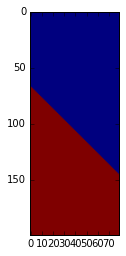

In [7]:
# We have to pass dtype=int or we get floats.
# We need ints because we're going to use for indexing later.
model = 1 + np.tri(depth, length, -depth//3, dtype=int)

plt.imshow(model)
plt.show()

In [8]:
model.dtype

dtype('int64')

Now set the upper part of the model — above the wedge — to zero (blue).

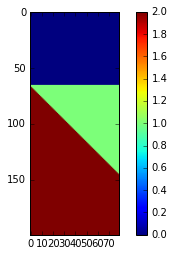

In [9]:
model[:depth//3,:] = 0

plt.imshow(model)
plt.colorbar()
plt.show()

Now we can make some Vp-rho pairs (rock 0 and rock 1).

In [10]:
rocks = np.array([[2700, 2750],
                  [2400, 2450],
                  [2800, 3000]])

Now we can use ['fancy indexing'](http://docs.scipy.org/doc/numpy/user/basics.indexing.html) to use `model`, which is an array of 0, 1, and 2, as the indices of the rock property pairs to 'grab' from `rocks`.

In [11]:
earth = rocks[model]

Now apply `np.product` to those Vp-rho pairs to get impedance at every sample.

In [12]:
imp = np.apply_along_axis(np.product, -1, earth)

## Model seismic reflections

Now we have an earth model — giving us acoustic impedance everywhere in this 2D grid — we define a function to compute reflection coefficients for every trace.

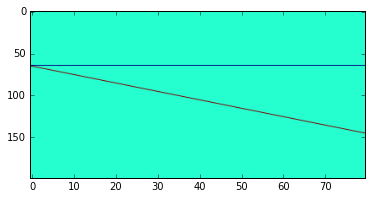

In [13]:
def make_rc(imp):
    upper = imp[ :-1, :]
    lower = imp[1:  , :]
    
    return (lower - upper) / (lower + upper)

rc = make_rc(imp)

plt.imshow(rc, aspect=0.2)
plt.show()

NumPy does give us an easier way to do this...

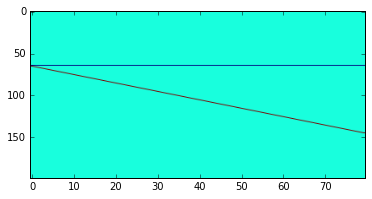

In [14]:
plt.imshow(np.diff(imp, axis=0), aspect=0.2)

We'll use `scipy.signal.ricker` to make a wavelet:

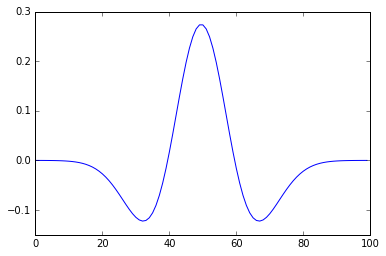

In [15]:
from scipy.signal import ricker

f = 25
wavelet = ricker(100, 1000/(4*f))

plt.plot(wavelet)
plt.show()

Now apply 1D convolution to every trace:

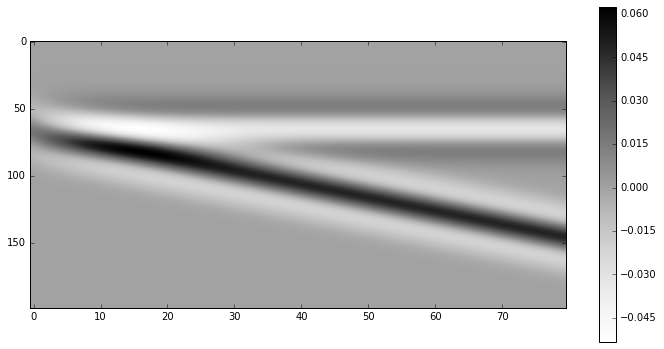

In [16]:
def convolve(trace):
    return np.convolve(trace, wavelet, mode='same')

synth = np.apply_along_axis(convolve,
                            axis=0,
                            arr=rc)

plt.figure(figsize=(12,6))
plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.colorbar()
plt.show()

## Measure amplitude at the peak

In [17]:
apparent = np.amin(synth, axis=0)
t_apparent = np.argmin(synth, axis=0)

actual = synth[depth//3, :]
t_actual = np.ones_like(t_apparent) * depth//3

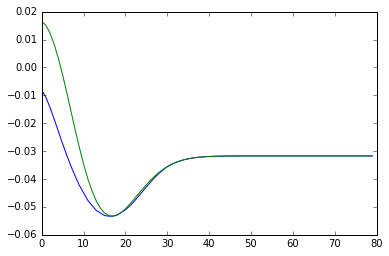

In [18]:
plt.plot(apparent)
plt.plot(actual)
plt.show()

In [19]:
t_apparent = t_apparent.astype(np.float)
t_apparent[0] = np.nan

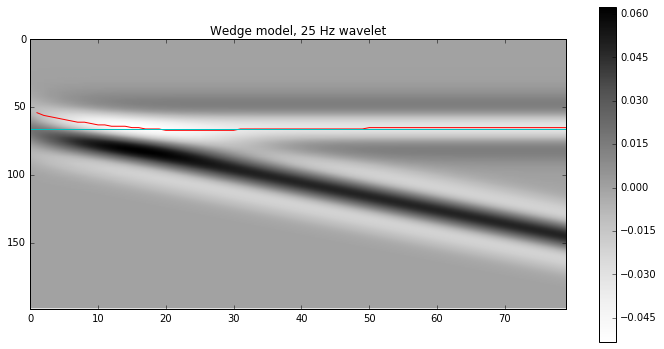

In [20]:
plt.figure(figsize=(12,6))

# Plot seismic
plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.colorbar()

# Plot horizons
plt.plot(t_apparent, 'r')
plt.plot(t_actual, 'c')

plt.xlim([0, 79])
plt.ylim([199, 0])
plt.title("Wedge model, {} Hz wavelet".format(f))
plt.show()

## Find the tuning thickness

We can find the thickness at which the amplitude peak starts... this is called the tuning thickness. 

In [21]:
tuning = np.argmin(actual)
vp = 2400
wavelength = 2 * 1000 * (vp / f) / vp  # in milliseconds TWT

print("Tuning thickness is {:.1f} ms, or 1/{:.1f} wavelength".format(tuning, wavelength/tuning))

Tuning thickness is 17.0 ms, or 1/4.7 wavelength


## A really cool model

Let's load an image and use it as a model.

In [30]:
import matplotlib.image as mpimg

img = mpimg.imread('../data/Hubbard_etal_2014.png')

This is just a 4-channel PNG (red, green, blue, alpha).

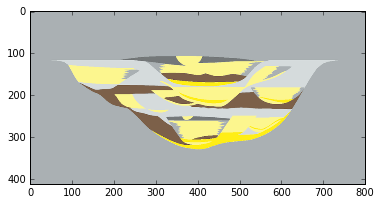

In [31]:
plt.imshow(img)

Let's pretend we can make impedance by averaging the channels (there are lots of equally geologically silly ways to do this).

In [23]:
imp = np.apply_along_axis(np.mean, -1, img)

Now carry on as before.

In [26]:
rc = make_rc(imp)
synth = np.apply_along_axis(convolve,
                            axis=0,
                            arr=rc)

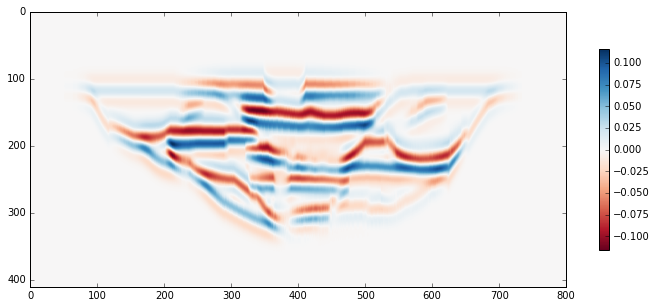

In [34]:
plt.figure(figsize=(12,12))
plt.imshow(synth, cmap="RdBu")
plt.colorbar(shrink=0.3)
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>